In [69]:
# Import libraries

import pandas as pd
import numpy as np

import scipy.stats as stats
import os
import random

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


os.getcwd()
os.chdir('D:\Qurantine\Blog\ANOVA Test')

In [70]:
#Load data
StatewiseTestingDetails=pd.read_csv('./StatewiseTestingDetails.csv')
population_india_census2011=pd.read_csv('./population_india_census2011.csv')

In [71]:
population_india_census2011.head()

,Sno,State,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [72]:
StatewiseTestingDetails.head()

,Date,State,TotalSamples,Negative,Positive
0,17-04-2020,Andaman and Nicobar Islands,1403,1210.0,12.0
1,24-04-2020,Andaman and Nicobar Islands,2679,NaN,27.0
2,27-04-2020,Andaman and Nicobar Islands,2848,NaN,33.0
3,01-05-2020,Andaman and Nicobar Islands,3754,NaN,33.0
4,02-04-2020,Andhra Pradesh,1800,1175.0,132.0


In [73]:
StatewiseTestingDetails['Positive'].sort_values().head()

510    0.0
501    0.0
502    0.0
503    0.0
504    0.0
Name: Positive, dtype: float64

In [74]:
#List down the states which have 0 corona cases
StatewiseTestingDetails['State'][StatewiseTestingDetails['Positive']==0].unique()

array(['Nagaland', 'Sikkim'], dtype=object)

In [75]:
#List down the states which have 1 corona cases
StatewiseTestingDetails['State'][StatewiseTestingDetails['Positive']==1].unique()

array(['Arunachal Pradesh', 'Mizoram'], dtype=object)

In [76]:
##We see that there're many entries with 0. That means no case has been detected. So we can add 1 in all entries.
#So while perfroming any sort of Data transformation that involves log in it , won't give error.
StatewiseTestingDetails['Positive']=StatewiseTestingDetails['Positive']+1

In [77]:
StatewiseTestingDetails['Positive'].sort_values()

510    1.0
501    1.0
502    1.0
503    1.0
504    1.0
      ... 
731    NaN
732    NaN
733    NaN
734    NaN
755    NaN
Name: Positive, Length: 759, dtype: float64

In [78]:
#Imput missing values by median of each state
stateMedianData=StatewiseTestingDetails.groupby('State')[['Positive']].median().\
                                    reset_index().rename(columns={'Positive':'Median'})
stateMedianData.head()

,State,Median
0,Andaman and Nicobar Islands,31.0
1,Andhra Pradesh,814.0
2,Arunachal Pradesh,3.0
3,Assam,35.0
4,Bihar,106.5


In [79]:
StatewiseTestingDetails.head()

,Date,State,TotalSamples,Negative,Positive
0,17-04-2020,Andaman and Nicobar Islands,1403,1210.0,13.0
1,24-04-2020,Andaman and Nicobar Islands,2679,NaN,28.0
2,27-04-2020,Andaman and Nicobar Islands,2848,NaN,34.0
3,01-05-2020,Andaman and Nicobar Islands,3754,NaN,34.0
4,02-04-2020,Andhra Pradesh,1800,1175.0,133.0


In [80]:
for index,row in StatewiseTestingDetails.iterrows():
    if pd.isnull(row['Positive']):
        StatewiseTestingDetails['Positive'][index]=int(stateMedianData['Median'][stateMedianData['State']==row['State']])
        

C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
StatewiseTestingDetails['Positive'].sort_values()

510        1.0
501        1.0
502        1.0
503        1.0
504        1.0
        ...   
456    10499.0
457    11507.0
458    12297.0
459    12975.0
460    14542.0
Name: Positive, Length: 759, dtype: float64

In [82]:
#Merge StatewiseTestingDetails & population_india_census2011 dataframes
data=pd.merge(StatewiseTestingDetails,population_india_census2011,on='State')

In [83]:
##Sort the Data Frame
data['Positive'].sort_values()

510        1.0
501        1.0
502        1.0
503        1.0
504        1.0
        ...   
456    10499.0
457    11507.0
458    12297.0
459    12975.0
460    14542.0
Name: Positive, Length: 756, dtype: float64

In [84]:
#Write a function to create densityGroup bucket 
def densityCheck(data):
    data['density_Group']=0
    for index,row in data.iterrows():
        status=None
        i=row['Density'].split('/')[0]
        try:
            if (',' in i):
                i=int(i.split(',')[0]+i.split(',')[1])
            elif ('.' in i):
                i=round(float(i))
            else:
                i=int(i)
        except ValueError as err:
            pass
        try:
            if (0<i<=300):
                status='Dense1'
            elif (300<i<=600):
                status='Dense2'
            elif (600<i<=900):
                status='Dense3'
            else:
                status='Dense4'
        except ValueError as err:
            pass
        data['density_Group'].iloc[index]=status
    return data  
    


In [85]:
data.columns


Index(['Date', 'State', 'TotalSamples', 'Negative', 'Positive', 'Sno',
       'Population', 'Rural population', 'Urban population', 'Area', 'Density',
       'Gender Ratio'],
      dtype='object')

In [86]:
data['Positive'].sort_values()

510        1.0
501        1.0
502        1.0
503        1.0
504        1.0
        ...   
456    10499.0
457    11507.0
458    12297.0
459    12975.0
460    14542.0
Name: Positive, Length: 756, dtype: float64

In [87]:
#Map each state as per its density group
data=densityCheck(data)
#We'll export this data so we can use it for Two - way ANOVA test.
stateDensity=data[['State','density_Group']].drop_duplicates().sort_values(by='State')


C:\Users\PraveenKumar\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [88]:
data['Positive'].sort_values()

510        1.0
501        1.0
502        1.0
503        1.0
504        1.0
        ...   
456    10499.0
457    11507.0
458    12297.0
459    12975.0
460    14542.0
Name: Positive, Length: 756, dtype: float64

In [89]:
data.to_csv('data.csv',index=False)
stateDensity.to_csv('stateDensity.csv',index=False)


In [90]:
data.head()

,Date,State,TotalSamples,Negative,Positive,Sno,Population,Rural population,Urban population,Area,Density,Gender Ratio,density_Group
0,17-04-2020,Andaman and Nicobar Islands,1403,1210.0,13.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
1,24-04-2020,Andaman and Nicobar Islands,2679,NaN,28.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
2,27-04-2020,Andaman and Nicobar Islands,2848,NaN,34.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
3,01-05-2020,Andaman and Nicobar Islands,3754,NaN,34.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
4,02-04-2020,Andhra Pradesh,1800,1175.0,133.0,10,49577103,34966693,14610410,"162,968 km2 (62,922 sq mi)",303/km2 (780/sq mi),993,Dense2


In [91]:
data.describe()

,TotalSamples,Negative,Positive,Sno,Population,Rural population,Urban population,Gender Ratio
count,756.000000,622.000000,756.000000,756.000000,7.560000e+02,7.560000e+02,7.560000e+02,756.000000
mean,20809.206349,21024.863344,765.484127,15.423280,4.389466e+07,3.026369e+07,1.363096e+07,945.236772
std,30018.538287,30070.735073,1543.937276,9.688974,4.511697e+07,3.414342e+07,1.372764e+07,54.704173
min,58.000000,0.000000,1.000000,1.000000,2.740000e+05,2.899100e+04,1.434880e+05,818.000000
25%,2367.250000,2482.250000,34.000000,7.000000,6.864602e+06,2.627208e+06,1.026459e+06,918.000000
50%,8538.000000,8303.000000,213.000000,15.000000,3.120558e+07,1.960796e+07,9.620624e+06,948.000000
75%,24989.750000,24500.250000,726.250000,24.000000,6.854844e+07,3.746934e+07,2.006940e+07,976.000000
max,175323.000000,162349.000000,14542.000000,35.000000,1.998123e+08,1.553173e+08,5.081826e+07,1084.000000


In [92]:
#Rearrange dataframe

df=pd.DataFrame({'Dense1':data[data['density_Group']=='Dense1']['Positive'],
                 'Dense2':data[data['density_Group']=='Dense2']['Positive'],
                 'Dense3':data[data['density_Group']=='Dense3']['Positive'],
                 'Dense4':data[data['density_Group']=='Dense4']['Positive']})



In [93]:
data.isna().sum()

Date                  0
State                 0
TotalSamples          0
Negative            134
Positive              0
Sno                   0
Population            0
Rural population      0
Urban population      0
Area                  0
Density               0
Gender Ratio          0
density_Group         0
dtype: int64

In [94]:
data[data['Positive'].isna()]

,Date,State,TotalSamples,Negative,Positive,Sno,Population,Rural population,Urban population,Area,Density,Gender Ratio,density_Group


In [95]:
df.dtypes

Dense1    float64
Dense2    float64
Dense3    float64
Dense4    float64
dtype: object

In [30]:
####################### Approach 1.##########3

In [31]:
np.random.seed(1234)
dataNew=pd.DataFrame({'Dense1':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10),
                      'Dense2':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10),
                      'Dense3':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10),
                      'Dense4':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10)})

In [32]:
# np.random.seed(1234)
# dataNew=pd.DataFrame({'Dense1':data['Positive'][data['density_Group']=='Dense1'],
#                       'Dense2':data['Positive'][data['density_Group']=='Dense1'],
#                       'Dense3':data['Positive'][data['density_Group']=='Dense1'],
#                       'Dense4':data['Positive'][data['density_Group']=='Dense1']})

In [33]:
dataNew.head()

,Dense1,Dense2,Dense3,Dense4
0,679.0,3062.0,428.0,37.0
1,61.0,143.0,2.0,36.0
2,13.0,381.0,3.0,2.0
3,53.0,1165.0,37.0,3.0
4,10.0,55.0,1486.0,58.0


In [34]:
dataNew.describe()

,Dense1,Dense2,Dense3,Dense4
count,10.000000,10.000000,10.000000,10.000000
mean,385.200000,869.600000,484.900000,29.700000
std,699.187751,1010.450966,808.078578,30.514295
min,2.000000,55.000000,2.000000,1.000000
25%,10.750000,175.000000,11.500000,2.250000
50%,48.000000,452.500000,80.500000,29.500000
75%,524.500000,1085.750000,406.500000,39.250000
max,2186.000000,3062.000000,2388.000000,95.000000


In [35]:
dataNew['Dense1'].sort_values().head()

5     2.0
6     8.0
4    10.0
2    13.0
8    43.0
Name: Dense1, dtype: float64

In [36]:
dataNew.describe()

,Dense1,Dense2,Dense3,Dense4
count,10.000000,10.000000,10.000000,10.000000
mean,385.200000,869.600000,484.900000,29.700000
std,699.187751,1010.450966,808.078578,30.514295
min,2.000000,55.000000,2.000000,1.000000
25%,10.750000,175.000000,11.500000,2.250000
50%,48.000000,452.500000,80.500000,29.500000
75%,524.500000,1085.750000,406.500000,39.250000
max,2186.000000,3062.000000,2388.000000,95.000000


In [37]:
dataNew['Dense1'].sort_values().head()

5     2.0
6     8.0
4    10.0
2    13.0
8    43.0
Name: Dense1, dtype: float64

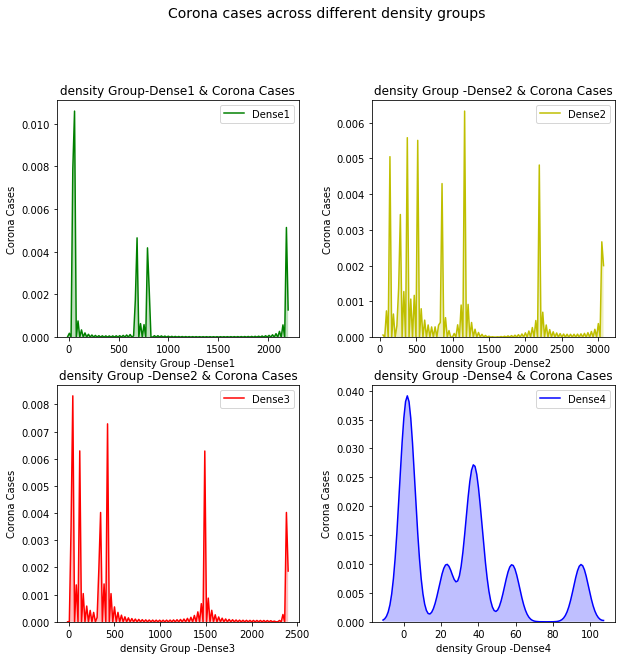

In [38]:
#Plot number of Corona cases across different density groups to check their distribution.
fig = plt.figure(figsize=(10,10))
title = fig.suptitle("Corona cases across different density groups", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.set_title("density Group-Dense1 & Corona Cases")
ax1.set_xlabel("density Group -Dense1")
ax1.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense1'], ax=ax1, shade=True,bw=4, color='g')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense2")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense2'], ax=ax2, shade=True,bw=4, color='y')

ax2 = fig.add_subplot(2,2,3)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense3")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense3'], ax=ax2, shade=True,bw=4, color='r')

ax2 = fig.add_subplot(2,2,4)
ax2.set_title("density Group -Dense4 & Corona Cases")
ax2.set_xlabel("density Group -Dense4")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense4'], ax=ax2, shade=True,bw=4, color='b')

In [39]:
## Apply BoxCox Transformation to bring the data to close to Gaussian Distribution 
dataNew['Dense1'],fitted_lambda = stats.boxcox(dataNew['Dense1'])
dataNew['Dense2'],fitted_lambda = stats.boxcox(dataNew['Dense2'])
dataNew['Dense3'],fitted_lambda = stats.boxcox(dataNew['Dense3'])
dataNew['Dense4'],fitted_lambda = stats.boxcox(dataNew['Dense4'])

In [40]:
##Apply log transformation to treat outliers and to bring to normal distribution
# dataNew = np.log(dataNew + 1)

In [41]:
dataNew.describe()

,Dense1,Dense2,Dense3,Dense4
count,10.000000,10.000000,10.000000,10.000000
mean,3.321081,7.444709,4.648780,3.691623
std,1.634094,2.038956,3.106635,2.726171
min,0.674420,4.563609,0.702392,0.000000
25%,2.158446,6.057879,1.809328,0.865555
50%,3.328508,7.454978,4.629876,4.818343
75%,4.694312,8.786689,6.746233,5.439094
max,5.755306,10.470520,9.055306,7.471679


In [42]:
dataNew.head()

,Dense1,Dense2,Dense3,Dense4
0,5.089940,10.470520,6.816592,5.316842
1,3.507428,5.834316,0.702392,5.260163
2,2.320648,7.220173,1.121958,0.744038
3,3.405425,8.909784,3.871437,1.230105
4,2.104378,4.563609,8.422814,6.292992


In [43]:
dataNew['Dense1'].describe()

count    10.000000
mean      3.321081
std       1.634094
min       0.674420
25%       2.158446
50%       3.328508
75%       4.694312
max       5.755306
Name: Dense1, dtype: float64

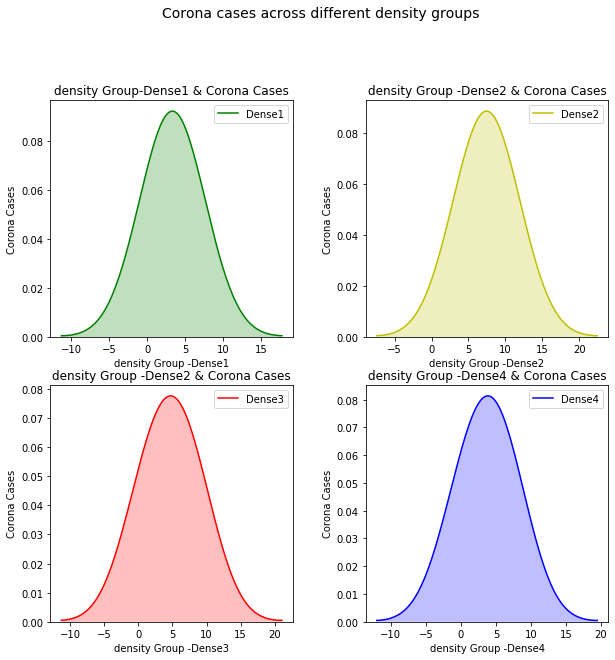

In [44]:
#Plot different density groups
fig = plt.figure(figsize=(10,10))
title = fig.suptitle("Corona cases across different density groups", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.set_title("density Group-Dense1 & Corona Cases")
ax1.set_xlabel("density Group -Dense1")
ax1.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense1'], ax=ax1, shade=True,bw=4, color='g')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense2")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense2'], ax=ax2, shade=True,bw=4, color='y')

ax2 = fig.add_subplot(2,2,3)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense3")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense3'], ax=ax2, shade=True,bw=4, color='r')

ax2 = fig.add_subplot(2,2,4)
ax2.set_title("density Group -Dense4 & Corona Cases")
ax2.set_xlabel("density Group -Dense4")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense4'], ax=ax2, shade=True,bw=4, color='b')

In [45]:
##############Assumptions check - Normality
stats.shapiro(dataNew['Dense1'])

(0.951483428478241, 0.6860718131065369)

In [46]:
stats.shapiro(dataNew['Dense2'])

(0.9591981172561646, 0.7766914963722229)

In [47]:
stats.shapiro(dataNew['Dense3'])

(0.9178347587585449, 0.3392496705055237)

In [48]:
stats.shapiro(dataNew['Dense4'])


(0.8782293796539307, 0.12451621890068054)

In [49]:
# Levene variance test  
stats.levene(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])

LeveneResult(statistic=1.858493196841099, pvalue=0.15411466144785818)

In [50]:
##p-value is more than 0.05 , So we can say that variances among groups are equal.

In [51]:
F, p = stats.f_oneway(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])
print('F statistic =', F, 'p value :',p)

F statistic = 5.816538917038426 p value : 0.002389369371815838


In [67]:
F, p = stats.f_oneway(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=5.817, p=0.002


In [52]:
#Rearrange DataFrame
newDf=dataNew.stack().to_frame().reset_index().rename(columns={'level_1':'density_Group',
                                                               0:'Count'})
del newDf['level_0']


In [53]:
################ using Ols Model
model = ols('Count ~ C(density_Group)', newDf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     5.817
Date:                Wed, 13 May 2020   Prob (F-statistic):            0.00239
Time:                        16:22:54   Log-Likelihood:                -90.411
No. Observations:                  40   AIC:                             188.8
Df Residuals:                      36   BIC:                             195.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.3211      0.773      4.295      0.000       1.753       4.889
C(density_Group)[T.Dense2]     4.1236      1.093      3.771      0.001       1.906       6.341
C(density_Group)[T.Dense3]     1.3277      1.093      1.214      0.233      -0.890       3.545
C(density_Group)[T.Dense4]     0.3705      1.093      0.339      0.737      -1.847       2.588
==============================================================================
Omnibus:                        4.464   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                1.833
Skew:                          -0.084   Prob(JB):                        0.400
Kurtosis:                       1.965   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 3, 36) =  5.817, p =  0.0024


In [55]:
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(density_Group),104.308564,3.0,5.816539,0.002389
Residual,215.197180,36.0,NaN,NaN


In [56]:
#The F-statistic= 76.48 and the p-value= 8.557817e-33 which is indicating that there is an overall significant 
#effect of density_Group on corona positive cases. However, we don’t know where the difference between desnity_groups is yet.
# This is in the post-hoc section. 

#So Based on p-value we can reject the H0; that is there's no significant difference as per density of an area 
#and number of corona cases

In [57]:
#So what if you find statistical significance?  Multiple comparison tests

#When you conduct an ANOVA, you are attempting to determine if there is a statistically significant difference among the groups.
#If you find that there is a difference, you will then need to examine where the group differences lay.

In [58]:
newDf.dtypes

density_Group     object
Count            float64
dtype: object

In [59]:
newDf.head()

,density_Group,Count
0,Dense1,5.089940
1,Dense2,10.470520
2,Dense3,6.816592
3,Dense4,5.316842
4,Dense1,3.507428


In [60]:
#Post hoc test
mc = statsmodels.stats.multicomp.MultiComparison(newDf['Count'],newDf['density_Group'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Dense1 Dense2   4.1236 0.0031  1.1788  7.0685   True
Dense1 Dense3   1.3277 0.6094 -1.6171  4.2725  False
Dense1 Dense4   0.3705    0.9 -2.5743  3.3154  False
Dense2 Dense3  -2.7959  0.068 -5.7408  0.1489  False
Dense2 Dense4  -3.7531 0.0079 -6.6979 -0.8083   True
Dense3 Dense4  -0.9572 0.7965  -3.902  1.9877  False
----------------------------------------------------


In [61]:
#tuckey HSD test clearly says that there's a significant difference between Group1 & Group4

In [62]:
#Above results from Tukey HSD suggests that except Dense1-Dense4 groups, all other pairwise comparisons for number of 
#corona cases rejects null hypothesis and indicates statistical significant differences.

In [63]:
### Normality Assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9612231254577637 0.1843944638967514


In [64]:
#Homogeneity of variances Assumption check
w, pvalue = stats.bartlett(newDf['Count'][newDf['density_Group']=='Dense1'], newDf['Count'][newDf['density_Group']=='Dense2']
                           , newDf['Count'][newDf['density_Group']=='Dense3'], newDf['Count'][newDf['density_Group']=='Dense4'])
print(w, pvalue)

4.0618671528689685 0.2548606240430252


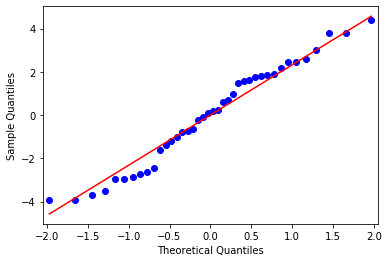

In [65]:
## Q-Q Plot for Normal Distribution check-
#Check the Normal distribution of residuals
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()